# 取最多的 20 組表情 group， 弄成 balance 資料
## 目標
> ### 1. 由 tomek link 後的資料 (767695 筆)，將前 20 高的 group 選出來
> ### 2. smote 將少的資料補到 20 個 group 的平均

### 1. Tomek Link mamual : 
https://imbalanced-learn.org/stable/under_sampling.html#tomek-s-links
### 2. smote + enn mamual : 
https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html
### 3. smote
https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

In [95]:
#! pip install -U scikit-learn
#! pip install -U imbalanced-learn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time, math

import sklearn
print(f'scikit-learn version: {sklearn.__version__}')
from sklearn.model_selection import train_test_split



import imblearn

from imblearn.over_sampling import SMOTE 
print(f'imbalanced-learn version: {imblearn.__version__}')

import warnings
warnings.filterwarnings("ignore")

scikit-learn version: 1.1.0
imbalanced-learn version: 0.9.1


## 匯入資料 (使用做過 tomek link 、已取出前 20 名、已將測試集丟出去的 group 的資料)
`20train.pkl`、`20trainlabel.pkl`

In [1]:
#path_ = r'C:\Users\e2414\OneDrive\桌面\專題\AllData\training'  #資料從哪裡來
path_ = r'F:\專題\AllData\training\final_training' 

path_test = r'F:\專題\AllData\training\final_training\測試集再sampling'
path_ori = r'F:\專題\AllData\training\final_training\原始資料'
path_imb = r'F:\專題\AllData\training\final_training\十萬imbal'

path_bal = r'F:\專題\AllData\training\final_training\較bal'
path_pca = r'F:\專題\AllData\training\final_training\PCA'
path_tse = r'F:\專題\AllData\training\final_training\tomek_smote_enn'
#path_tsne = r'F:\專題\AllData\training\final_training\tsne'

In [4]:
%%time
with open(path_pca+ r"/X_train_total_pc20.pkl", "rb") as f:
    train = pickle.load(f)
    
with open(path_bal+ r"/y_train_pc20_sam.pkl", "rb") as f:
    trainlabel = pickle.load(f)
    
print(train.shape)
print(len(trainlabel))


(745961, 20)
58291
Wall time: 3.16 s


In [5]:
label = list(range(1, 40+1))

In [10]:
trainlabel = trainlabel.tolist()

In [12]:
%%time
train_count = [trainlabel.count(i) for i in label]
#train_mean = np.quantile(train_count, q = 0.25)
train_mean = np.mean(train_count)

print(train_count)
print(train_mean)

[1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1447, 1431, 1182, 1238, 1092, 901]
1457.275
Wall time: 28 ms


In [13]:
from matplotlib.font_manager import FontProperties  

fontset01 = FontProperties(fname=r"c:\windows\fonts\mingliu.ttc", size=12) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Wall time: 562 ms


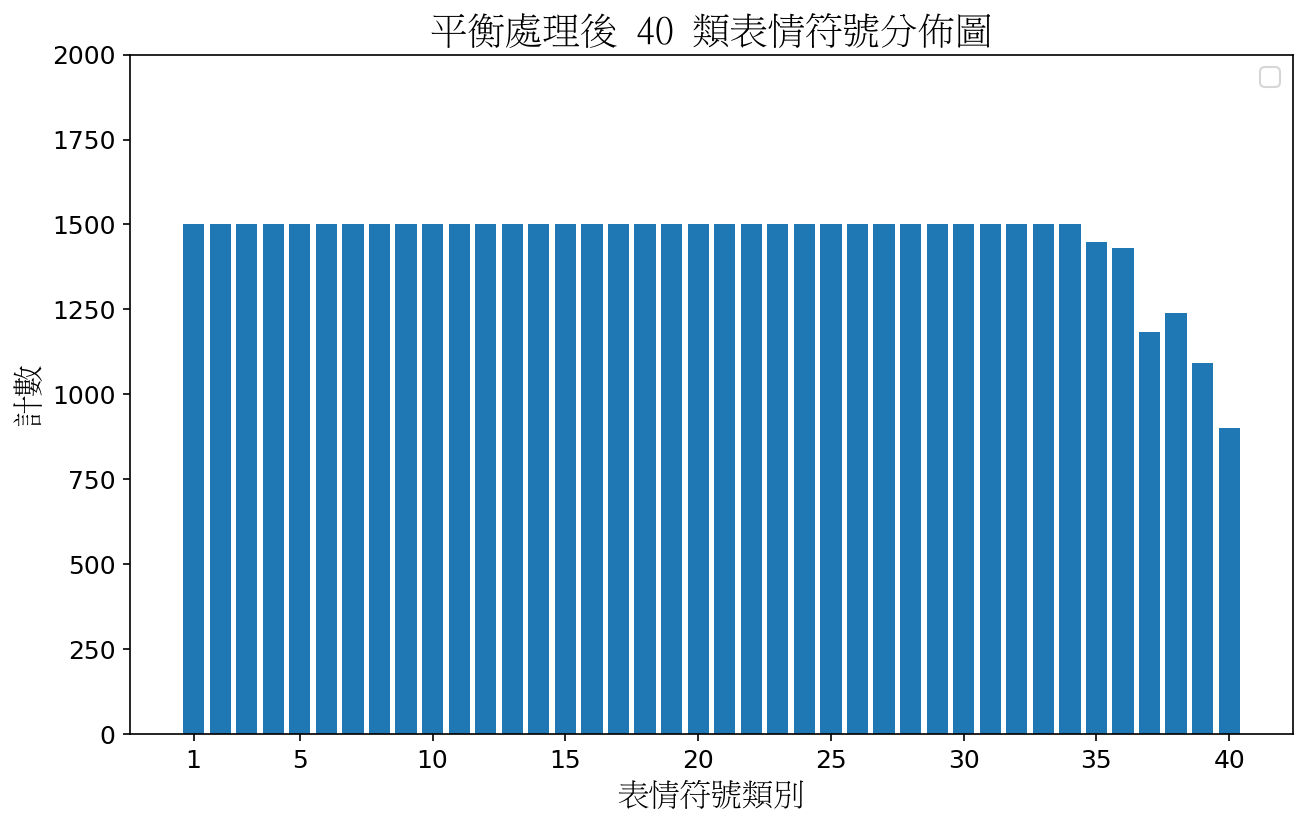

In [22]:
%%time

fig= plt.figure(figsize= [10, 6], dpi=150)
plt.bar(label, train_count)#, color = 'deepskyblue')
#plt.axhline(y=train_mean, c="coral",  lw=3, label = '平均值', ls="--")

xlabel = [1]+ list(range(5, 40+1, 5))
plt.xticks(xlabel, size = 12) 
plt.yticks(size = 12)
plt.ylim(0, 2000)
#plt.title(f'40 emoji groups, Total = {sum(train_count)}', size = 14)
plt.title(f'平衡處理後 40 類表情符號分佈圖', size = 18, fontproperties= fontset01)

#plt.title(f'40 類表情符號分佈圖', size = 18, fontproperties= fontset01)

plt.xlabel('表情符號類別', size = 15, fontproperties= fontset01)
plt.ylabel('計數', size = 15, fontproperties= fontset01)

plt.legend(fontsize=16, prop= fontset01)
#plt.grid(color='whitesmoke')

plt.savefig(path_+ r'/40_bal.jpg')

<hr>

### 使用 smote 
- 字典內放 要 smote 到多少

### 20 個 group 中，哪些 group 需要 smote，smote 多少

In [86]:
smote_label = [i+1 for i, v in enumerate(list(train_count<train_mean)) if v ==True]

print(f'針對這幾個 group: {smote_label} 做 smote 到 {int(train_mean)} 個')

針對這幾個 group: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40] 做 smote 到 18649 個


In [87]:
smonum = [int(train_mean)]*len(smote_label)
smo = dict(zip(smote_label, smonum))
print(smo)

{14: 18649, 15: 18649, 16: 18649, 17: 18649, 18: 18649, 19: 18649, 20: 18649, 21: 18649, 22: 18649, 23: 18649, 24: 18649, 25: 18649, 26: 18649, 27: 18649, 28: 18649, 29: 18649, 30: 18649, 31: 18649, 32: 18649, 33: 18649, 34: 18649, 35: 18649, 36: 18649, 37: 18649, 38: 18649, 39: 18649, 40: 18649}


In [88]:
%%time 
X_res, y_res = SMOTE(smo).fit_resample(train, trainlabel)

print(X_res.shape)
print(len(y_res))

#12:01開始跑

(1100348, 20)
1100348
Wall time: 6.59 s


In [89]:
after_train_count = [y_res.count(i) for i in label]
after_train_mean = np.mean(after_train_count)

print(after_train_count)
print(after_train_mean)

[99928, 88854, 64269, 58830, 53435, 39380, 40830, 30052, 29669, 25622, 22693, 22700, 20563, 18649, 18649, 18649, 18649, 18649, 18649, 18649, 18649, 18649, 18649, 18649, 18649, 18649, 18649, 18649, 18649, 18649, 18649, 18649, 18649, 18649, 18649, 18649, 18649, 18649, 18649, 18649]
27508.7


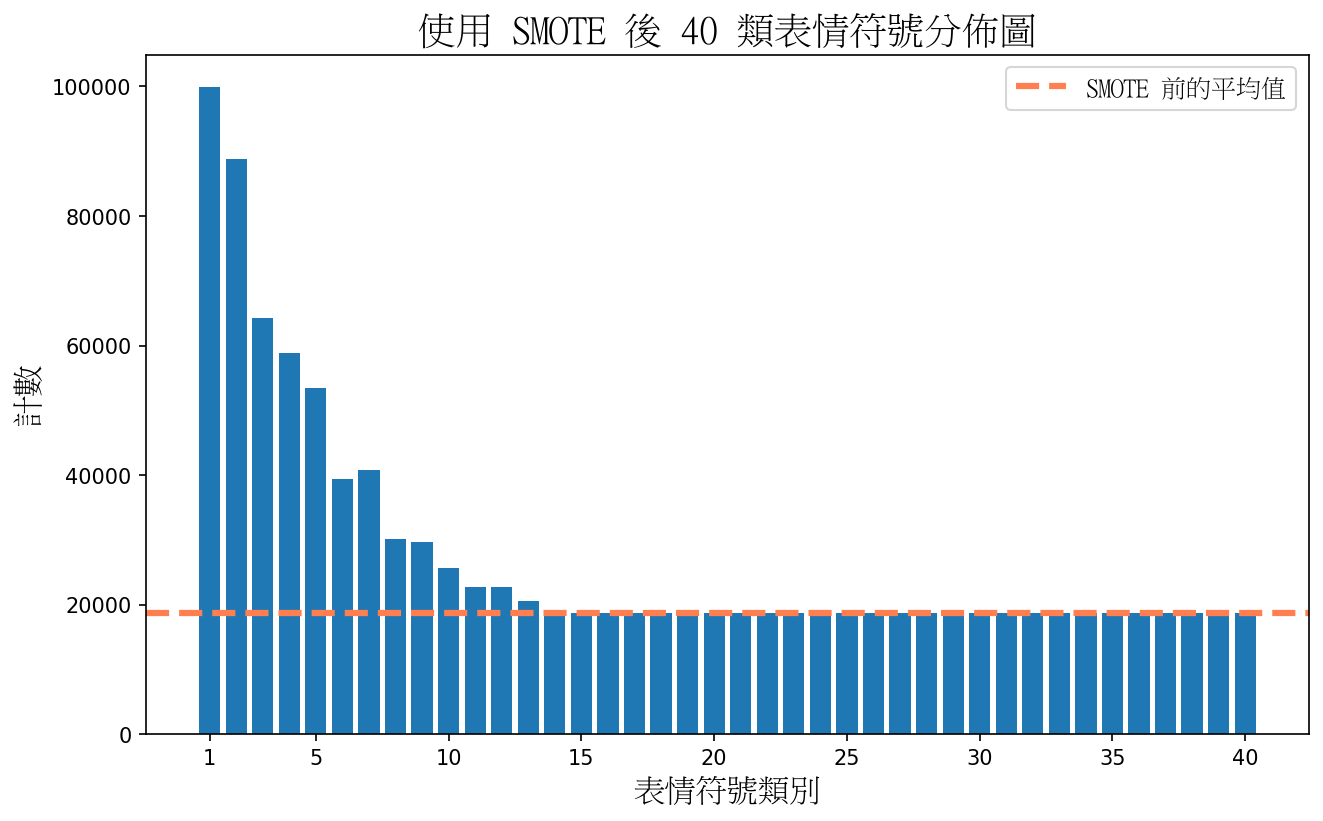

In [90]:
fig= plt.figure(figsize= [10, 6], dpi=150)
plt.bar(label, after_train_count)#, color = '#00B2EE')
plt.axhline(y=train_mean2, c="coral", ls="--", lw=3, label = 'SMOTE 前的平均值')

xlabel = [1]+ list(range(5, 40+1, 5))
plt.xticks(xlabel) 
plt.title(f'使用 SMOTE 後 40 類表情符號分佈圖', size = 18, fontproperties= fontset01)
plt.xlabel('表情符號類別', size = 15, fontproperties= fontset01)
plt.ylabel('計數', size = 15, fontproperties= fontset01)
plt.legend(fontsize=16, prop= fontset01)
plt.savefig(path_+ r'/40_smote.jpg')





### 匯出檔案

In [26]:
%%time
with open(path_tse+ '/X_smo_g40.pkl','wb') as f:
    pickle.dump(X_res, f)

with open(path_tse+ '/y_smo_g40.pkl','wb') as f:
    pickle.dump(y_res, f)

Wall time: 6.29 s


<hr>

### 匯入 smote + enn 畫圖

In [91]:
%%time
with open(path_tse+ r"/X_smoenn_g40.pkl", "rb") as f:
    train = pickle.load(f)
    
with open(path_tse+ r"/y_smoenn_g40.pkl", "rb") as f:
    trainlabel = pickle.load(f)
    
print(train.shape)
print(len(trainlabel))

(310821, 20)
310821
Wall time: 1.43 s


In [92]:
%%time
train_count = [trainlabel.count(i) for i in label]
#train_mean = np.quantile(train_count, q = 0.25)
train_mean = np.mean(train_count)

print(train_count)
print(train_mean)

[6011, 4893, 4266, 509, 20864, 404, 1802, 924, 1390, 2216, 2436, 976, 833, 1246, 383, 2976, 4695, 4852, 4667, 6186, 5911, 7547, 6835, 8330, 10209, 11072, 10968, 12699, 14027, 7980, 13491, 14127, 13035, 14660, 13357, 14780, 15897, 13669, 15113, 14585]
7770.525
Wall time: 128 ms


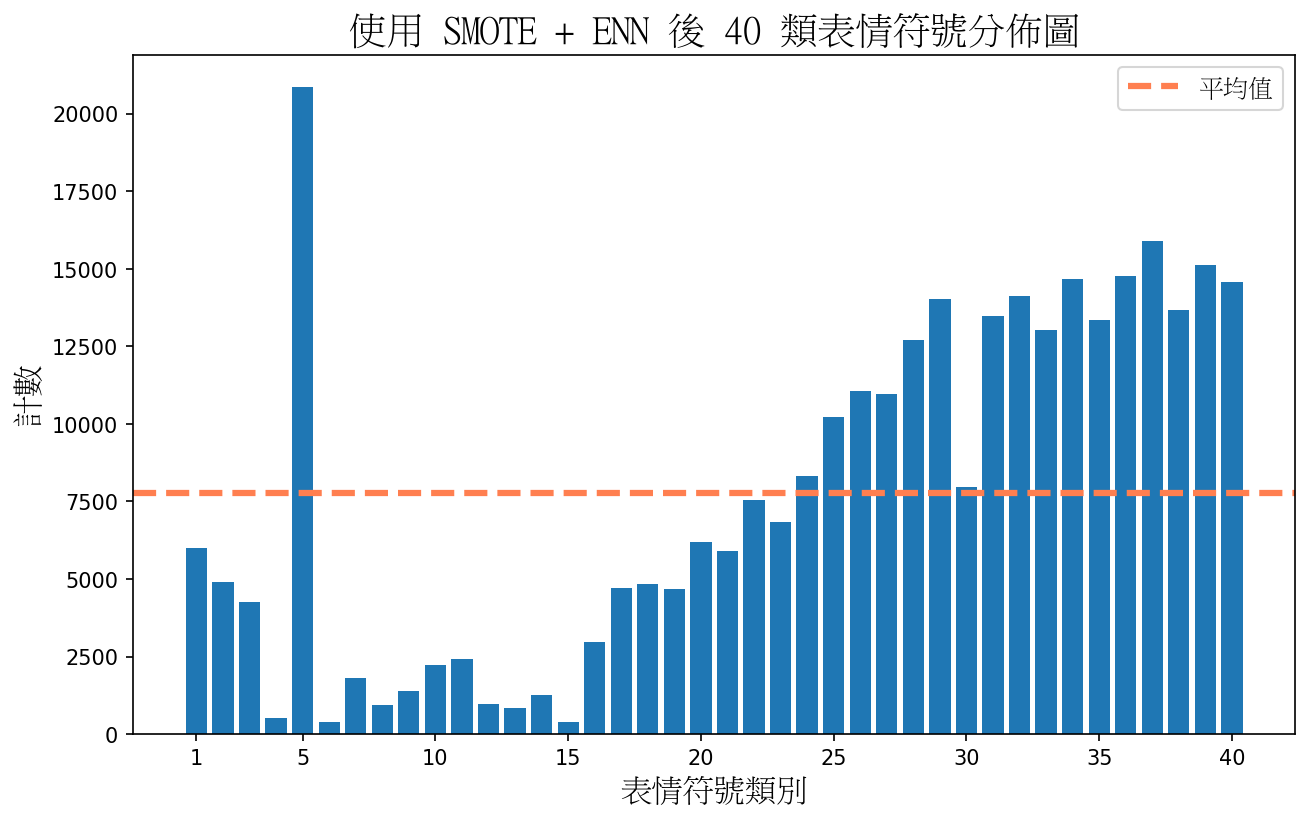

In [93]:
fig= plt.figure(figsize= [10, 6], dpi=150)
plt.bar(label, train_count)#, color = '#00B2EE')
plt.axhline(y=train_mean, c="coral", ls="--", lw=3, label = '平均值')

xlabel = [1]+ list(range(5, 40+1, 5))
plt.xticks(xlabel) 
plt.title(f'使用 SMOTE + ENN 後 40 類表情符號分佈圖', size = 18, fontproperties= fontset01)
plt.xlabel('表情符號類別', size = 15, fontproperties= fontset01)
plt.ylabel('計數', size = 15, fontproperties= fontset01)
plt.legend(fontsize=15, prop= fontset01)
plt.savefig(path_+ r'/40_smote+enn.jpg')


In [4]:
path_correct = r'F:\專題\AllData\training\final_training\每個group 被判斷的機率'

### 畫

In [5]:
with open(path_correct+ r"/pc20_knn_bal_k136_測試集3中1.pkl", "rb") as f:
    bal = pickle.load(f)
    
with open(path_correct+ r"/total_knn_pc20_k96_測試集3中1.pkl", "rb") as f:
    total = pickle.load(f)

with open(path_correct+ r"/pc20_knn_smo_g40_k9.pkl", "rb") as f:
    smo = pickle.load(f)

In [96]:
bal.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])

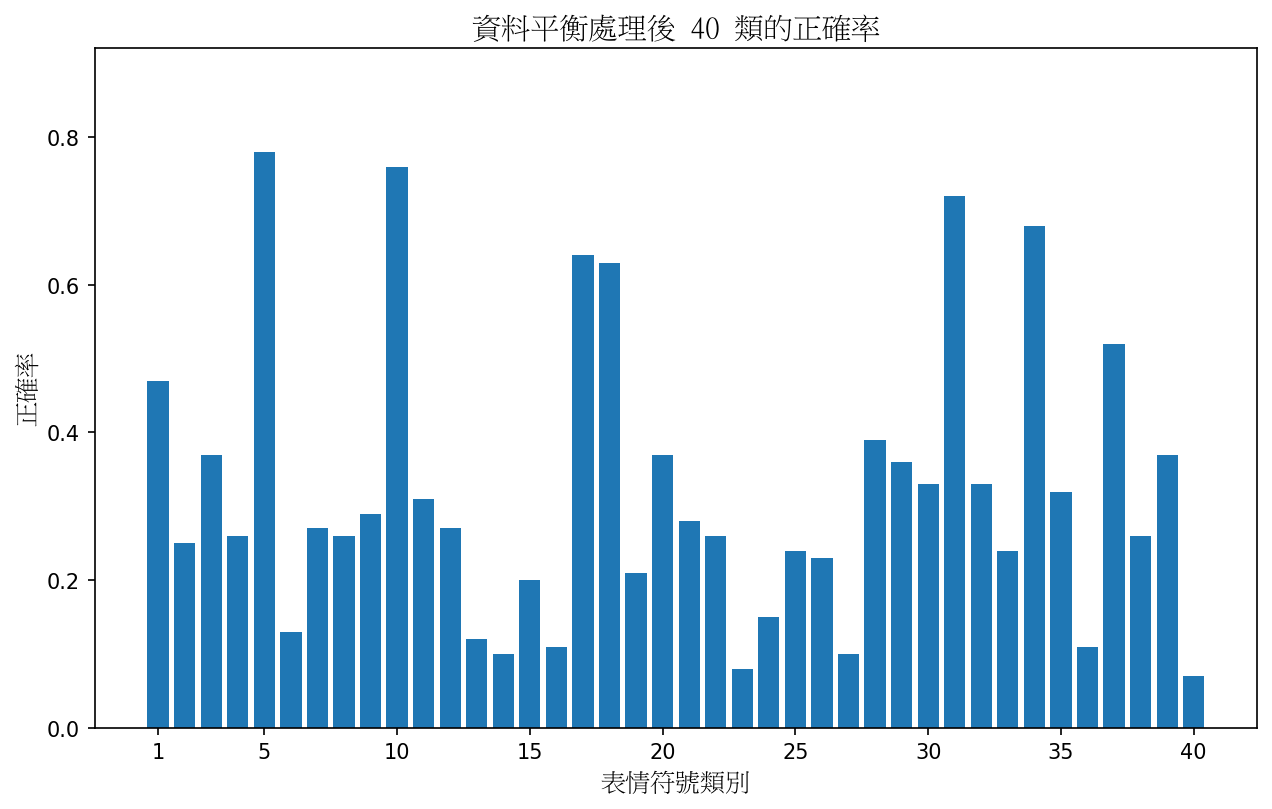

In [105]:
fig= plt.figure(figsize= [10, 6], dpi=150)
plt.bar(bal.keys(), bal.values())#, color = '#00B2EE')
#plt.axhline(y=np.mean(list(total.values())), c="coral", ls="--", lw=3)

xlabel = [1]+ list(range(5, 40+1, 5))
plt.xticks(xlabel) 
plt.title(f'資料平衡處理後 40 類的正確率', size = 14, fontproperties= fontset01)
plt.xlabel('表情符號類別', size = 12, fontproperties= fontset01)
plt.ylabel('正確率', size = 12, fontproperties= fontset01)
plt.ylim(0, 0.92)
#plt.legend(fontsize=15)
plt.savefig(path_+ r'/bal.jpg')


In [179]:
path_

'F:\\專題\\AllData\\training\\final_training'

In [259]:
#xxlabel = [1, 5, 10, 15, 20, 25, 30, 35, 40]
xlabel = [1]+ list(range(5, 40+1, 5))
print(xlabel)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


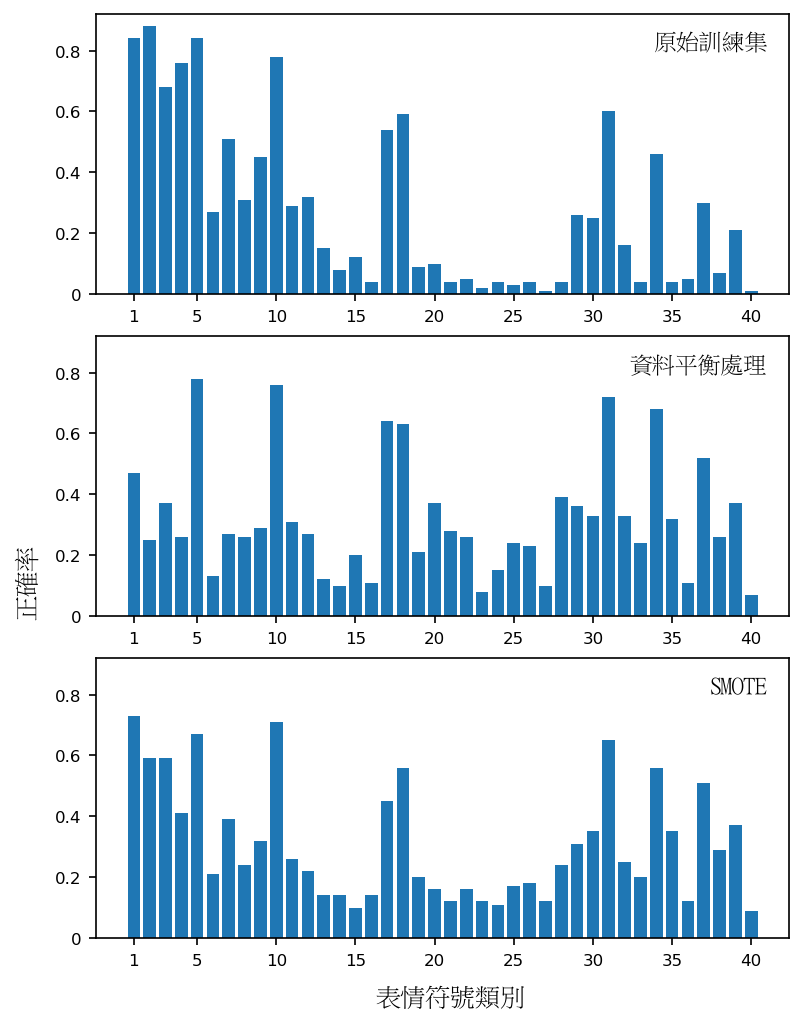

In [102]:

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (6, 8), dpi=150)


ax1.bar(total.keys(), total.values())
#ax1.set_title('Imbalance (original)', fontsize = 12)
ax1.set_xticks(xlabel, fontsize = 7) 
ax1.set_xticklabels(xlabel, fontsize = 8) 
ax1.set_ylim(0, 0.92)
ax1.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8], fontsize = 8) 
#ax1.axhline(y=np.mean(list(total.values())), xmin=0, xmax=40, color="coral", ls="--", lw=2.5, label = f'average acc: {round(np.mean(list(total.values())), 3)}')
#ax1.set_ylabel('Acc in each group', fontsize = 8)
ax1.text(41, 0.86, '原始訓練集', fontsize = 11, fontdict = {'weight':'bold'}, color="black", ha='right', va='top', fontproperties= fontset01)
#ax1.set_xlabel('emoji group', fontsize = 9)
#ax1.legend(fontsize = 8, frameon=False, loc='upper right')

ax2.bar(bal.keys(), bal.values())
#ax2.set_title('Balance', fontsize = 12)
ax2.set_xticks(xlabel, fontsize = 7) 
ax2.set_xticklabels(xlabel, fontsize = 8)
ax2.set_ylim(0, 0.92)
ax2.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8], fontsize = 8) 
#ax2.axhline(y=np.mean(list(bal.values())), xmin=0, xmax=40, color="coral", ls="--", lw=2.5, label = f'average acc: {round(np.mean(list(bal.values())), 3)}')
#ax2.set_ylabel('Acc in each group', fontsize = 8)
ax2.text(41, 0.86, '資料平衡處理', fontsize = 11, fontdict = {'weight':'bold'}, color="black", ha='right', va='top', fontproperties= fontset01)
#ax2.legend(fontsize = 8, frameon=False, loc='upper right')


ax3.bar(smo.keys(), smo.values())
#ax3.set_title('SMOTE', fontsize = 12)
ax3.set_xticks(xlabel, fontsize = 7) 
ax3.set_xticklabels(xlabel, fontsize = 8 )
ax3.set_ylim(0, 0.92)
ax3.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8], fontsize = 8) 
#ax3.axhline(y=np.mean(list(smo.values())), xmin=0, xmax=40, color="coral", ls="--", lw=2.5, label = f'average acc: {round(np.mean(list(smo.values())), 3)}')
ax3.text(41, 0.86, 'SMOTE', fontsize = 11, fontdict = {'weight':'bold'}, color="black", ha='right', va='top', fontproperties= fontset01) 
        #bbox=dict(facecolor='coral', edgecolor='none', pad = 5))#, boxstyle='round'

#ax3.set_ylabel('Acc in each group', fontsize = 8)
#ax3.legend(fontsize = 8, frameon=False, loc='upper right')

plt.subplots_adjust(left=0.13,
                    bottom=0.13, 
                    #right=0.9, 
                    top=0.9, 
                    #wspace=0.25, 
                    hspace=0.15)

plt.figtext(0.44, 0.075, s= '表情符號類別', fontsize = 12, fontproperties= fontset01)
plt.figtext(0.04, 0.4, s = '正確率', rotation='vertical', fontsize = 12, fontproperties= fontset01)

plt.savefig(path_+ r'/acc_all.jpg')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


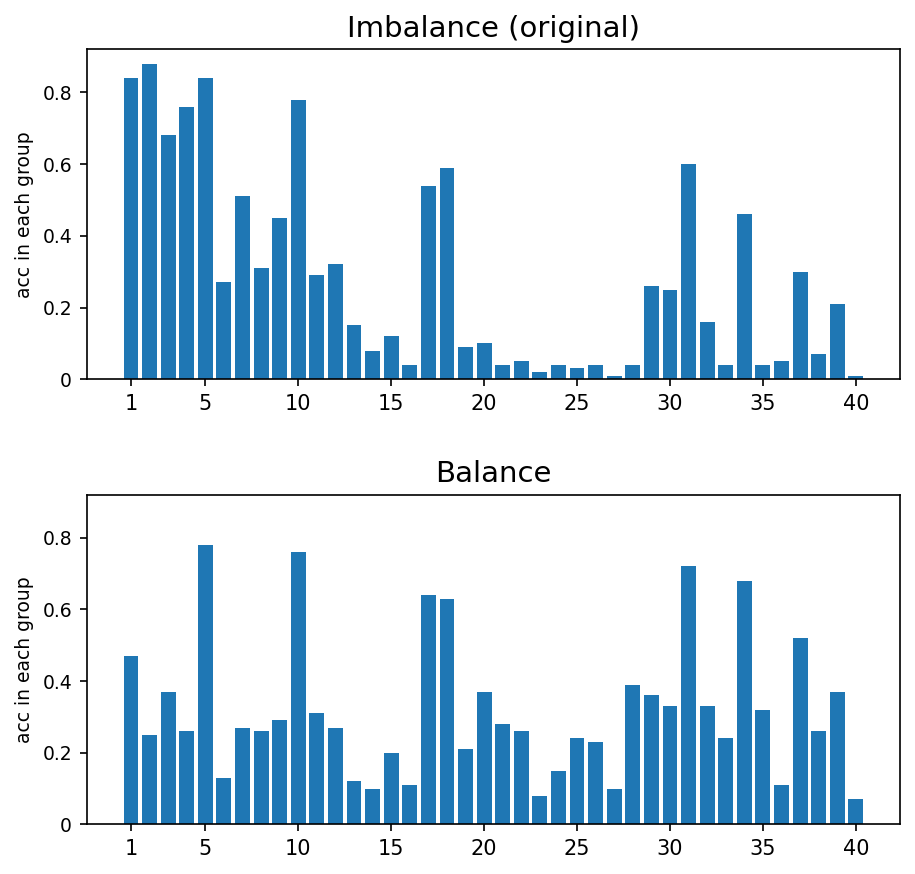

In [333]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (7, 10/3*2), dpi=150)


ax1.bar(total.keys(), total.values())
ax1.set_title('Imbalance (original)', fontsize = 14, fontproperties= fontset01)
ax1.set_xticks(xlabel, fontsize = 7) 
ax1.set_xticklabels(xlabel, fontsize = 10) 
ax1.set_ylim(0, 0.92)
ax1.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8], fontsize = 9) 
#ax1.axhline(y=np.mean(list(total.values())), xmin=0, xmax=40, color="coral", ls="--", lw=2.5, label = f'average acc: {round(np.mean(list(total.values())), 3)}')
ax1.set_ylabel('acc in each group', fontsize = 9)
ax1.legend(fontsize = 9, frameon=False, loc='upper right')

ax2.bar(bal.keys(), bal.values())
ax2.set_title('Balance', fontsize = 14, fontproperties= fontset01)
ax2.set_xticks(xlabel, fontsize = 7) 
ax2.set_xticklabels(xlabel, fontsize = 10) 
ax2.set_ylim(0, 0.92)
ax2.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8], fontsize = 9) 
#ax2.axhline(y=np.mean(list(bal.values())), xmin=0, xmax=40, color="coral", ls="--", lw=2.5, label = f'average acc: {round(np.mean(list(bal.values())), 3)}')
ax2.set_ylabel('acc in each group', fontsize = 9)
ax2.legend(fontsize = 9, frameon=False, loc='upper right')


plt.subplots_adjust(#left=0.125,
                    #bottom=0.1, 
                    #right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)

plt.figtext(0.44, 0.075, s= 'Emoji group', fontsize = 12)
plt.figtext(0.04, 0.4, s = 'Accuracy in each group', rotation='vertical', fontsize = 12)

plt.savefig(path_+ r'/acc_im_b.jpg')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


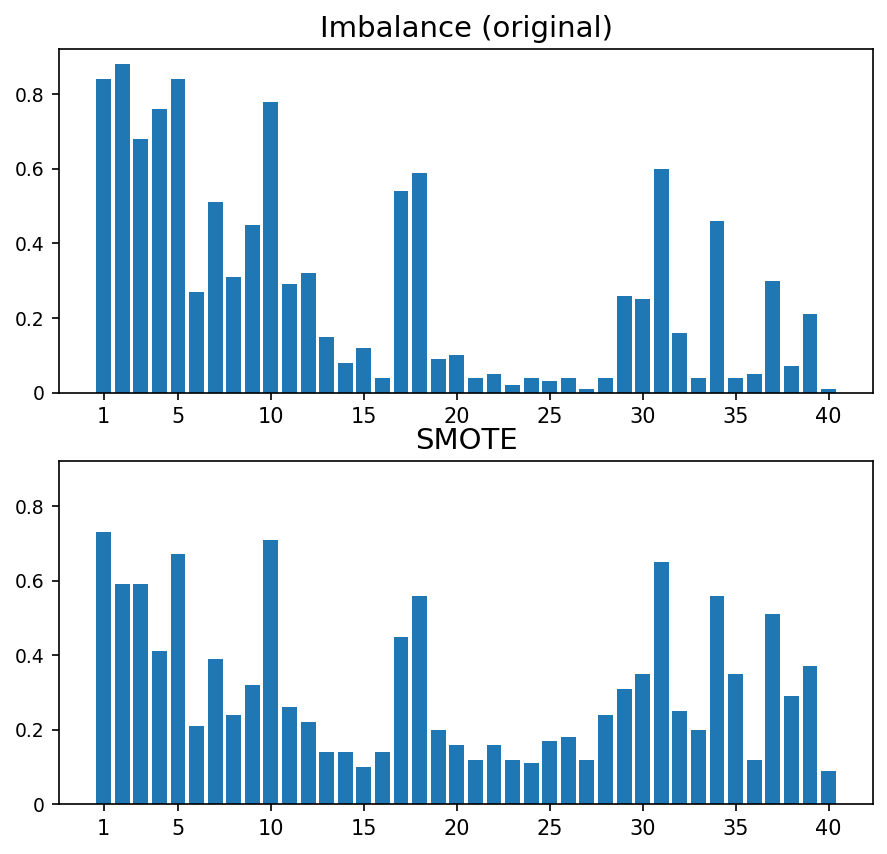

In [469]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (7, 10/3*2), dpi=150)


ax1.bar(total.keys(), total.values())
ax1.set_title('Imbalance (original)', fontsize = 14)
ax1.set_xticks(xlabel, fontsize = 7) 
ax1.set_xticklabels(xlabel, fontsize = 10) 
ax1.set_ylim(0, 0.92)
ax1.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8], fontsize = 9) 
#ax1.axhline(y=np.mean(list(total.values())), xmin=0, xmax=40, color="coral", ls="--", lw=2.5, label = f'average acc: {round(np.mean(list(total.values())), 3)}')
#ax1.set_ylabel('Acc in each group', fontsize = 9)
#ax1.set_xlabel('Emoji group', fontsize = 9)

ax1.legend(fontsize = 9, frameon=False, loc='upper right')

ax2.bar(smo.keys(), smo.values())
ax2.set_title('SMOTE', fontsize = 14)
ax2.set_xticks(xlabel, fontsize = 7) 
ax2.set_xticklabels(xlabel, fontsize = 10) 
ax2.set_ylim(0, 0.92)
ax2.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8], fontsize = 9) 
#ax2.axhline(y=np.mean(list(smo.values())), xmin=0, xmax=40, color="coral", ls="--", lw=2.5, label = f'average acc: {round(np.mean(list(smo.values())), 3)}')
#ax2.set_ylabel('acc in each group', fontsize = 9)
#ax2.legend(fontsize = 9, frameon=False, loc='upper right')


plt.savefig(path_+ r'/acc_im_smo.jpg')